# Kupffer Analysis Data Processing

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('talk')
sns.set_style('white')

# Preprocessing

In [2]:
workingDirectory = '/home/h1bennet/liverStrains/results/180430_kupffer_21wk_tba/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

## ATAC QC
requires tag directories

In [3]:
%%bash
if [ ! -d ./qc_atac/ ]; then mkdir ./qc_atac; fi

In [4]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_atac/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_atac/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_atac/'+sample+'/'):
        if file.endswith(".log"):
            print('./tag_directories_atac/'+sample+'/'+file)
            f = open('./tag_directories_atac/'+sample+'/'+file)
    bowtie_log = f.read().split()
    qc_stats.loc[sample, 'totalReads'] = int(bowtie_log[0])
    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(bowtie_log[15])
    qc_stats.loc[sample, 'multiMappedReads'] = int(bowtie_log[21])
    qc_stats.loc[sample, 'unmappedReads'] = int(bowtie_log[10])
    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
    qc_stats.loc[sample, 'mappedFraction'] = \
                                            (qc_stats.loc[sample, 'totalReads'] \
                                            - qc_stats.loc[sample, 'unmappedReads']) \
                                            / qc_stats.loc[sample, 'totalReads']
    
qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_atac/mapping_stats.tsv', sep='\t')

./tag_directories_atac/C57B6J_BloodLy6cHi8_ATAC_NoTx_MS_20171119/1_mouse_C57B6J_Male_BloodLy6cHi8_ATAC_NoTx_MS_l20171119_GCTCATGA_trimmed.mm10.bowtie2.log
./tag_directories_atac/NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS/NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS_20161019.mm10.bowtie2.log
./tag_directories_atac/C57B6J_BloodLy6cHi3_ATAC_NoTx_MS_20171119/1_mouse_C57B6J_Male_BloodLy6cHi3_ATAC_NoTx_MS_l20171119_CGTGTCCG_trimmed.mm10.bowtie2.log
./tag_directories_atac/NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS/NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS_20161019.mm10.bowtie2.log
./tag_directories_atac/NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS/NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS_20161019.mm10.bowtie2.log
./tag_directories_atac/NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS/NC

**Make QC Plots**

In [5]:
# make plots - set seaborn factors
sns.set_style('whitegrid')
sns.set_context('poster')

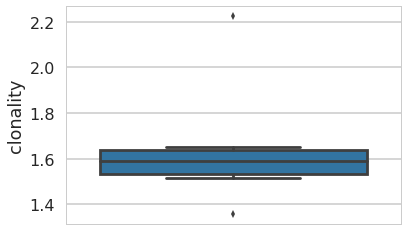

In [6]:
# clonality boxplot
fig = sns.boxplot(y=qc_stats['clonality']).get_figure()
fig.savefig('./qc_atac/clonality_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


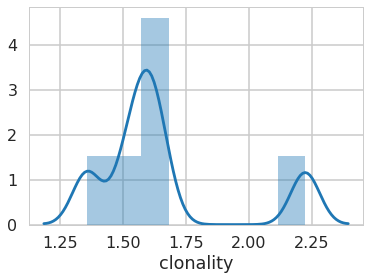

In [7]:
# clonality distplot
fig = sns.distplot(qc_stats['clonality']).get_figure()
fig.savefig('./qc_atac/clonality_distplot_hb.pdf', bbox_inches='tight')

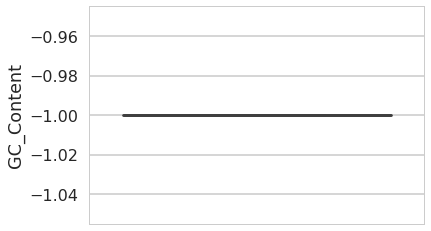

In [8]:
# GC_Content boxplot
fig = sns.boxplot(y=qc_stats['GC_Content']).get_figure()
fig.savefig('./qc_atac/GC_Content_boxplot_hb.pdf', bbox_inches='tight')

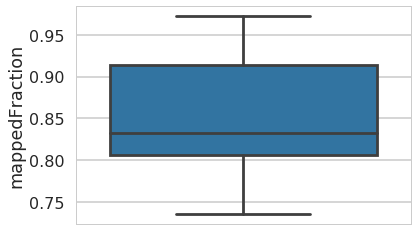

In [9]:
# mapped fraction boxplot
fig = sns.boxplot(y=qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_atac/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


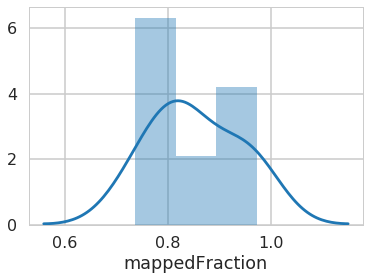

In [10]:
# mapped fraction distplot
fig = sns.distplot(qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_atac/mappedFraction_distplot_hb.pdf', bbox_inches='tight')

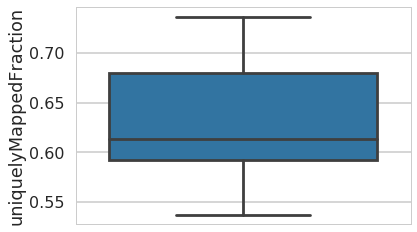

In [11]:
# uniquely Mapped Fraction boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction']).get_figure()
fig.savefig('./qc_atac/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


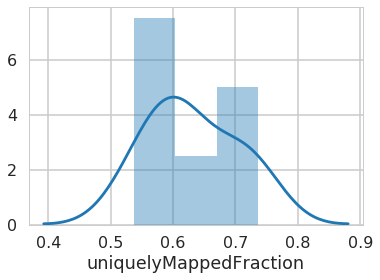

In [12]:
# uniquely Mapped Fraction distplot
fig = sns.distplot(qc_stats['uniquelyMappedFraction']).get_figure()
fig.savefig('./qc_atac/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')

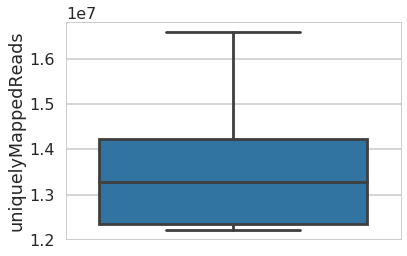

In [13]:
# uniquely Mapped Reads boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedReads']).get_figure()
fig.savefig('./qc_atac/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


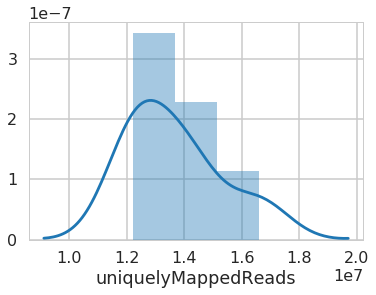

In [14]:
# uniquely Mapped Reads distplot
fig = sns.distplot(qc_stats['uniquelyMappedReads']).get_figure()
fig.savefig('./qc_atac/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

## Create Script To Process ATAC tag directories


In [15]:
# renaming dict to make naming more consistant
rename_dict = {
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS_20161019': 'ncorwt_kupffertim4neg_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS_20161019': 'ncorwt_kupffertim4neg_nashdiet_21wk_2',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS_20161019': 'ncorwt_kupffertim4pos_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS_20161019': 'ncorwt_kupffertim4pos_nashdiet_21wk_2',
    'C57BL6J_BloodLy6cHi_ATAC_NoTx_0week_Ly6Hi3_MS_20171119': 'ncorwt_bloodly6chi_controldiet_1',
    'C57BL6J_BloodLy6cHi_ATAC_NoTx_0week_Ly6Hi8_MS_20171119': 'ncorwt_bloodly6chi_controldiet_2',

}

In [16]:
%%bash
# delete the existing script file
rm ./peakCalling_homer.sh
# create a script file
touch ./peakCalling_homer.sh

# if directories don't exist, create them
if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi

In [17]:
with open('./peakCalling_homer.sh', 'w') as f:
    for tagdir, rename in rename_dict.items():
        find_peaks_idr = ['findPeaks', './tag_directories_atac/' + tagdir,
                          '-L', '0', '-C', '0', '-fdr', '0.9', '-style',
                          'factor', '-size', '200', '>',
                          workingDirectory + '/atac_peak_files/' + rename + '_peaks.tsv',
                          '&', '\n']
        find_peaks = ['findPeaks', './tag_directories_atac/' + tagdir,
                      '-style', 'factor', '-size', '200', '>',
                      workingDirectory + '/atac_peak_files/' + rename + '_default_peaks.tsv',
                      '&', '\n']
        # write commands to file
        f.write(' '.join(find_peaks_idr))
        f.write(' '.join(find_peaks))

### Run IDR 

In [18]:
%%bash
# delete the existing script file
rm ./run_idr.sh
# create a script file
touch ./run_idr.sh

# if directories don't exist, create them
if [ ! -d ./atac_idr/ ]; then mkdir ./atac_idr; fi

In [19]:
mylist = list(rename_dict.values())
mylist.sort()

In [20]:
import itertools
mylist = list(rename_dict.values())
mylist.sort()
with open('./run_idr.sh', 'w') as f:
    for i, j in itertools.combinations(mylist, r=2):
        run_idr = ['python', '/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                             workingDirectory + '/atac_peak_files/' + i + '_peaks.tsv',
                             workingDirectory + '/atac_peak_files/' + j + '_peaks.tsv',
                             './atac_idr/', '-threshold', '0.05', '&', '\n']
        if (i[:-2] == j[:-2]) & (i != j):
            f.write(' '.join(run_idr))

## ATAC TBA

#### Create script to run model

In [21]:
%%bash
# delete the existing script file
rm ./run_tba.sh
# create a script file
touch ./run_tba.sh

# if directories don't exist, create them
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi
if [ ! -d ./peak_sequences/ ]; then mkdir ./peak_sequences; fi
if [ ! -d ./background_files/ ]; then mkdir ./background_files; fi
if [ ! -d ./tba_output/ ]; then mkdir ./tba_output; fi

# for each peak file create several commands
for peak_file in ./atac_idr_peaks/*;

# generate name of bed file
do bed_file=${peak_file/tsv/bed};
bed_file=${bed_file/atac_idr_peaks/bed_files}
# call Homer pos2bed.pl to create bed file
echo "pos2bed.pl $peak_file > $bed_file" >> ./run_tba.sh

# generate peak sequence fasta file name
seq_file=${bed_file/peaks.bed/peaks.fasta};
seq_file=${seq_file/bed_files/peak_sequences};

# execute command to extract sequences
echo "/home/jtao/code/tba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba.sh

# generate background coordinates
echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_file mm10 ./background_files/">> ./run_tba.sh

# rename background file
bg_seq_file=${seq_file/peak_sequences/background_files};
bg_seq_file=${bg_seq_file/peaks.fasta/background.fasta};
echo "mv ./background_files/background.fasta $bg_seq_file">> ./run_tba.sh
echo "/home/jtao/code/tba/model_training/create_features.py -num_procs 40 $seq_file $bg_seq_file ./tba_output /home/jtao/code/tba/default_motifs/*">> ./run_tba.sh

# calculate motif scores for peaks and background
combined_features=${seq_file/peak_sequences/tba_output}
combined_features=${combined_features/.fasta/_combined_features.tsv}
labels=${combined_features/combined_features.tsv/labels.txt}
echo "/home/jtao/code/tba/model_training/train_classifier.py $combined_features $labels ./tba_output/">> ./run_tba.sh
coeff_path=${combined_features/combined_features.tsv/coefficients.tsv}
performance_path=${combined_features/combined_features.tsv/performance.tsv}
echo "mv ./tba_output/coefficients.tsv $coeff_path">> ./run_tba.sh
echo "mv ./tba_output/performance.tsv $performance_path">> ./run_tba.sh

# perform insilico mutagenesis
echo "/home/jtao/code/tba/model_training/calc_feature_significance.py $combined_features $labels ./tba_output/ -num_iterations 1">> ./run_tba.sh
significance_path=${combined_features/combined_features.tsv/significance.tsv}
echo mv ./tba_output/significance.tsv $significance_path>> ./run_tba.sh

done

### read in weight values

In [22]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:3])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [23]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:3])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


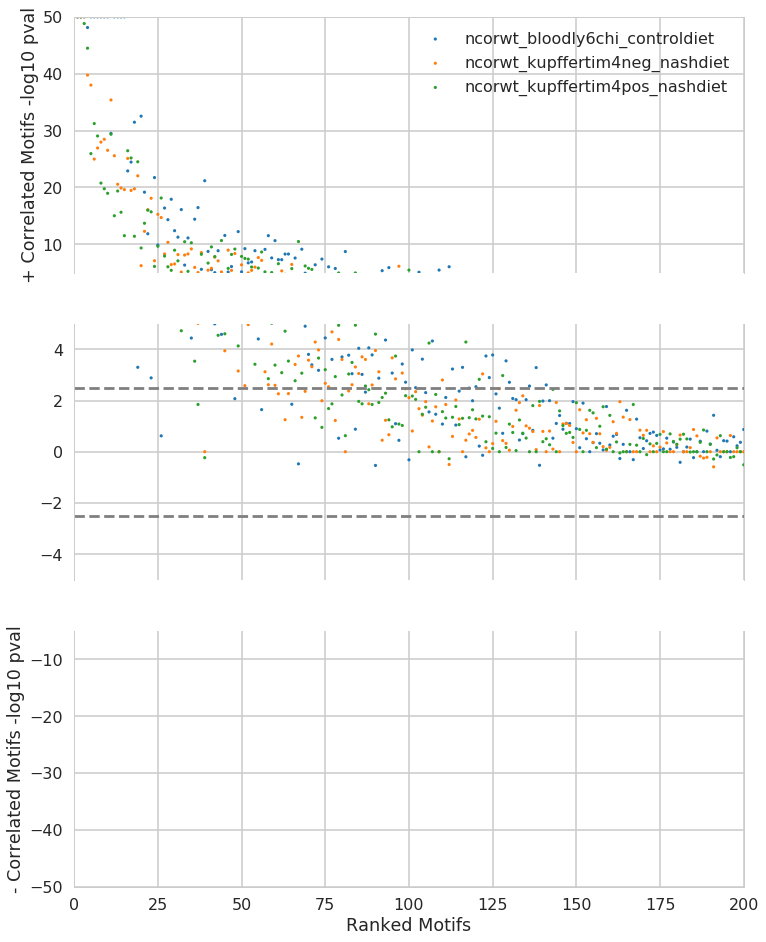

In [24]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,200)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')


### Create Heatmap of differential motifs

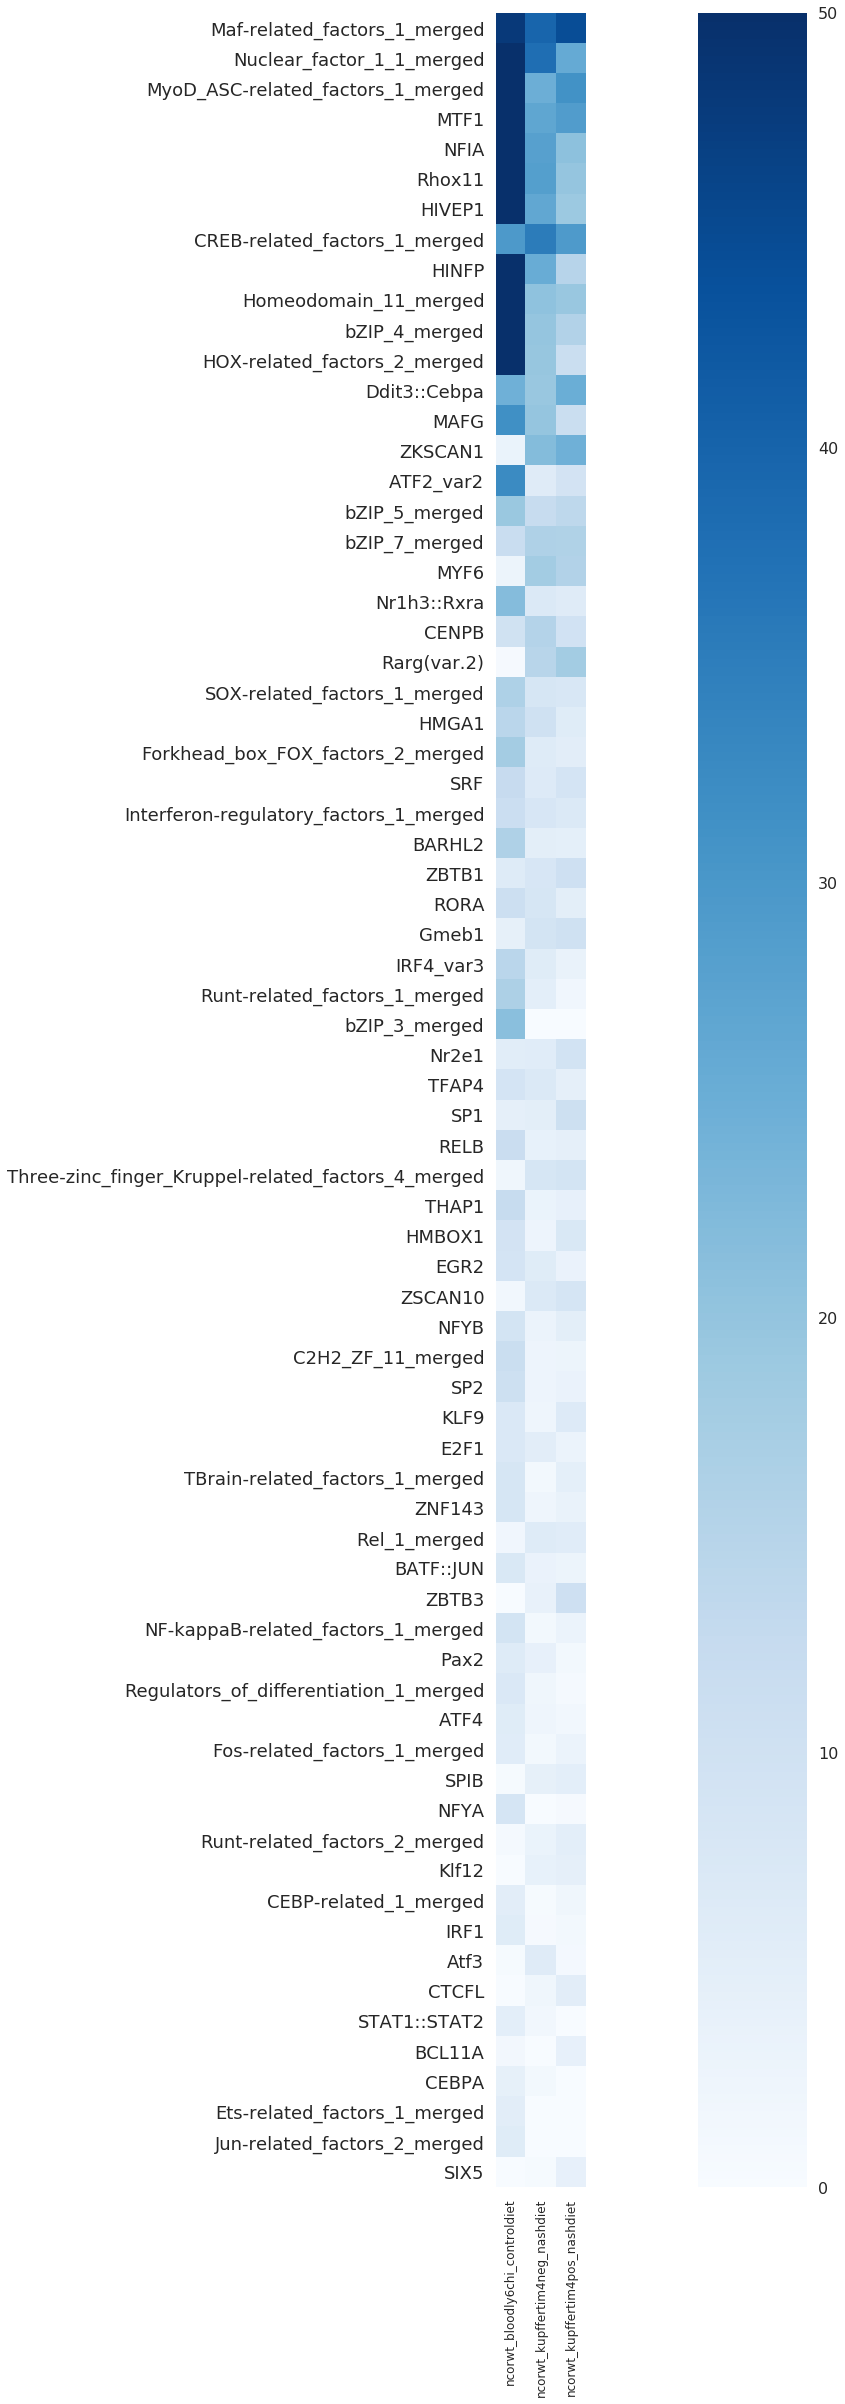

In [48]:
pseudocount = 1e-10 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);
# plt.savefig('./figures/tba_heatmap_heatmap.pdf',bbox_inches='tight')

## Compare HOMER Results to TBA

### Run Get Differential Peaks

In [26]:
%%bash
# delete the existing script file
rm ./run_getDifferentialPeaks.sh
# create a script file
touch ./run_getDifferentialPeaks.sh

# if directories don't exist, create them
if [ ! -d ./diff_peaks/ ]; then mkdir ./diff_peaks; fi

In [27]:
import itertools
# write differential peaks and merge peaks commands
with open('./run_getDifferentialPeaks.sh', 'w') as f:
    # write differential peaks and merge peaks commands
    # merge peaks into one file
    f.write('mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_idr/ncorwt_atac_merged_peaks.tsv\n')
    # merge tag directories for getDifferential peaks
    mylist=rename_dict.keys()
    merged_peaks=[]
    for i, j in itertools.combinations(mylist, r=2):
        if (i.split('_ATAC')[0] == j.split('_ATAC')[0]):
            # create output file name for merging peaks
            out_file = [x for x in i.split('_') if x in set(j.split('_'))]
            out_file = '_'.join(out_file)+'_merged_tag_dir'
            merge_peaks = ['makeTagDirectory', './tag_directories_atac/'+out_file,
                           '-d', './tag_directories_atac/'+i,
                           './tag_directories_atac/'+j+'\n']
            f.write(' '.join(merge_peaks))
            merged_peaks.append(out_file)
            
    # run get differential peaks
    for i, j in itertools.combinations(merged_peaks, r=2):
        get_diff = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+j, 
                    './tag_directories_atac/'+i, '>',
                    './diff_peaks/'+j+'_vs_'+i+'_diffpeaks.tsv\n']
        get_diff_rev = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+i, 
                    './tag_directories_atac/'+j, '>',
                    './diff_peaks/'+i+'_vs_'+j+'_diffpeaks.tsv\n']
        f.write(' '.join(get_diff))
        f.write(' '.join(get_diff_rev))

In [28]:
# next up implement homer get differential motifs!

### we can also try finding motifs with just the distal atac peak files

In [29]:
# # table this for now - can use to switch to doing homer on distal peaks only
# %%bash
# # get distal peaks since we are mainly interested in enhancers
# for peak_file in ./atac_idr_peaks/*;
# do dist_file=${peak_file/.tsv/_distal.tsv};
# echo $dist_file
# getDistalPeaks.pl $peak_file mm10 > $dist_file;
# done

### Process denovo motif results and read into data frame for analysis

In [76]:
import codecs
# p values stored at the 9 + 8n cells
# names of TFs stored at the 13 + 8n cells
denovo_results = {}
for homerfile in os.listdir('./find_motifs/'):
    tf_logp_dict = {}
    tf_logp_dict_full = {}
    # open homer file
    if not (homerfile.startswith('.') | ('vs' in homerfile)) :
        f = codecs.open(
            './find_motifs/' + homerfile + '/homerResults.html', 'r')
        denovo = f.read().split('</TD><TD>')
        # table is in columns of 8
        # log p value is at position 9 + 8n
        # tf name is at position 13 + 8n
        for i in range(len(denovo) // 8):
            tf = denovo[13 + 8*i].split('/')[0]
            tf_2 = tf.split('(')[0]
            tf_logp_dict[tf_2] = denovo[9 + 8*i]
        denovo_results[homerfile] = tf_logp_dict
            
        
# create matrix of de novo motif log ps
denovo_logp = -pd.DataFrame(denovo_results, dtype=float).fillna(0)
# set max to 50 so its more comparable to tba
denovo_logp[denovo_logp > 50] = 50
# sort based on mean value
denovo_logp = denovo_logp.reindex(index=denovo_logp.mean(1).sort_values(ascending=False).index)

### Plot homer de novo motifs score with TBA on same heatmap

In [111]:
# manually adjust the labels of denovo logp so we can compare to jenhan's script
new_index = list(denovo_logp.index)
new_index[0]= 'bZIP_4_merged'
new_index[1]= 'CTCFL'
new_index[2]= 'related_factors_3_merged'
new_index[7]= 'FOSL1'
new_index[9]= 'RUNX1'
new_index[10]= 'E2F-related_factors_3_merged'
new_index[11]= 'GATA-type_zinc_fingers_1_merged'
new_index[12]= 'CEBP-related_1_merged'
new_index[13]= 'bHLH-ZIP_factors_2_merged'
new_index[14]= 'CREB-related_factors_1_merged'
new_index[16]= 'Jun-related_factors_2_merged'
new_index[17]= 'Three-zinc_finger_Kruppel-related_factors_4_merged'
new_index[18]= 'Regulators_of_differentiation_1_merged_2A'
new_index[19]= 'Regulators_of_differentiation_1_merged_2D'
new_index[20]= 'Rel_1_merged'
new_index[23]= 'MYBL1'
new_index[24]= 'type_homeo_domain_factors_2_merged'
new_index[25]= 'Homeodomain_15_merged'
new_index[27]= 'RFX-related_factors_1_merged'
new_index[28]= 'Runt-related_factors_1_merged'
new_index[30]= 'POU_domain_factors_2_merged'
new_index[31]= 'Homeodomain_9_merged'
new_index[32]= 'Nkx2-5'
new_index[33]= 'NF-kappaB-related_factors_1_merged'
new_index[34]= 'NFAT-related_factors_2_merged_C3'
new_index[35]= 'NFAT-related_factors_2_merged_5'
new_index[36]= 'Regulators_of_differentiation_1_merged_2Ab'
new_index[37]= 'related_factors_1_merged'
new_index[38]= 'related_factors_4_merged'
new_index[39]= 'Crx'
new_index[40]= 'SRF'

In [118]:
denovo_logp.index = new_index
merged_frame = denovo_logp.merge(filtered_frame, left_index=True,
                                 right_index=True, how='outer')
merged_frame = merged_frame.fillna(0)
merged_frame = merged_frame.reindex(
    index=merged_frame.mean(1).sort_values(ascending=False).index)

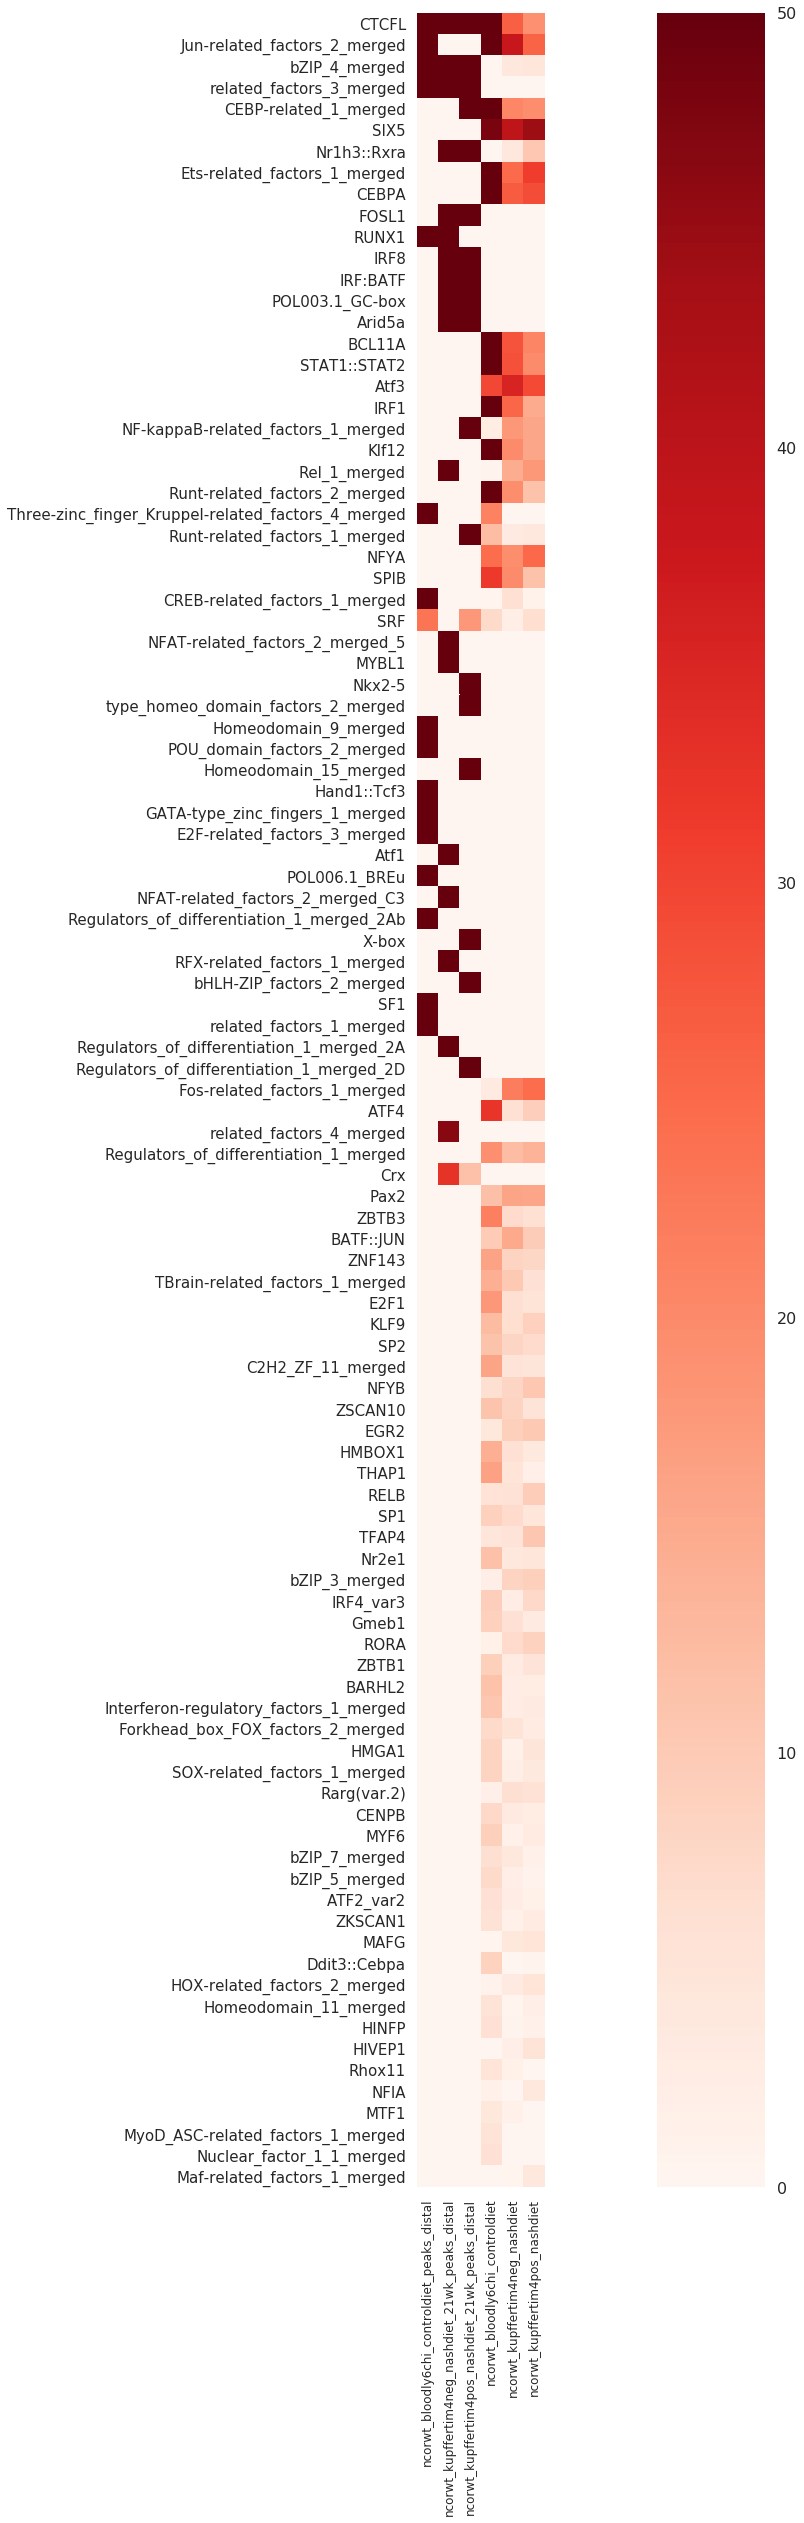

In [126]:
# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(merged_frame,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=15, labels = merged_frame.index.values);
hm.set_xticklabels(size=12, labels = merged_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap_homer_combined.pdf',bbox_inches='tight')

### Plot as subplots of same figure

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,20), sharey=False)
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax1)
pos = hm.get_position()

hm.set_yticks(range(0, filtered_frame.shape[0]));
hm.set_yticklabels(size=8, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

hm2 = sns.heatmap(denovo_logp,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax2)
pos = hm2.get_position()

hm2.set_yticks(range(0, denovo_logpy.shape[0]));
hm2.set_yticklabels(size=8, labels = denovo_logp.index.values,
                    verticalalignment='top');
hm2.set_xticklabels(size=12, labels = denovo_logp.columns.values, rotation=90);

# Integrate RNA Seq Data

## Process RNA Seq Data

### RNA QC

In [33]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [34]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
    txt = f.read()
    star_log = list(filter(None, re.split('\s|\|',txt)))
    qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
    qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
    qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
    qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
    qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
    qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
    qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
    qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    
qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

### Annotate and Compile RNA

In [82]:
%%bash
# if directories don't exist, create them
# if [ ! -d ./expression/ ]; then mkdir ./expression; fi

analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_3_MS_l20171111_TGACCA
		./tag_directories_rna/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_6and10_MS_l20171111_ACAGTG
		./tag_directories_rna/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_8_MS_l20171111_ACTTGA
		./tag_directories_rna/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_Pooled_MS_l20171111_CGATGT
		./tag_directories_rna/NCoRWT_Tim4NegKupffer_RNA_polyA_AMLNDiet_20week_LN203dM_JSS_TDT_16_11_28
		./tag_directories_rna/NCoRWT_Tim4NegKupffer_RNA_polyA_AMLNDiet_21week_LN200cM_JSS_TDT_16_12_05
		./tag_directories_rna/NCoRWT_Tim4NegKupffer_RNA_polyA_AMLNDiet_21week_LN201cM_JSS_TDT_16_12_05
		./tag_directories_rna/NCoRWT_Tim4PosKupffer_RNA_polyA_AMLNDiet_20week_LN203dM_JSS_TDT_16_11_28
		./tag_directories_rna/NCoRWT_Tim4PosKupffer_RNA_polyA_AMLNDiet_21week_LN200cM_JSS_TDT_16_12_05
		./tag_directories_rna/NCoRWT_Tim4PosKupffer_RNA_polyA_AMLNDiet_21week_LN201cM_JSS_TDT_16_12_05
	Input file format

In [83]:
%%bash
makeMultiWigHub.pl hrb_kupffer_21wk_rna mm10 -force -d ./tag_directories_rna/*


	Once finished, you will want to upload the following hub URL:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/hub.txt

	If loading to the Wash U Epigenome Browser, use:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/washU.hub.txt


	Visualization fragment length = 75
	Output file: ./tag_directories_rna/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_3_MS_l20171111_TGACCA/1_mouse_C57B6J_Male_BloodLy6cHi_RNA_polyA_NoTx_3_MS_l20171111_TGACCA.ucsc.bigWig
	No need to remove tags to get desired file size
	Generating bedGraph for chr1
	Generating bedGraph for chr10
	Generating bedGraph for chr11
	Generating bedGraph for chr12
	Generating bedGraph for chr13
	Generating bedGraph for chr14
	Generating bedGraph for chr15
	Generating bedGraph for chr16
	Generating bedGraph for chr17
	Generating bedGraph for chr18
	Generating bedGraph for chr19
	Generating bedGraph for chr2
	Generating bedGraph for chr3
	Generating bedGraph for chr4
	Generating bedGraph for chr5
	Generating bedGraph for chr

### RNA Data Wrangling
______
Goal is to get average expression of each transcription factor in dataset for each sample group

In [52]:
# import RNA Seq data
exp = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t', index_col=0)
exp.index.rename('refseq_id', inplace=True)
exp['gene'] = exp['Annotation/Divergence'].str.split('|').str[0]

# filter based on gene expression
exp_filt = ((exp.iloc[:, 7:-1] != 0).sum(1) == 10)
exp = exp.loc[exp_filt, :]

# filter based on average expression
avg_filt = (exp.iloc[:, 7:-1].mean(1) > 4)
exp = exp.loc[avg_filt, :]

#filter based on length
exp = exp.loc[exp.Length >= 250, :]

# create average expression matrix
exp_avg = pd.DataFrame([exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Ly6c'))].mean(1),
                       exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Tim4Pos'))].mean(1),
                       exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Tim4Neg'))].mean(1)],
                       index=['ncorwt_bloodly6chi_controldiet', 'ncorwt_kupffertim4pos_nashdiet', 'ncorwt_kupffertim4neg_nashdiet']).T

# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt',
                          sep='\t', names=['refseq_id', 'gene'],
                          index_col=0)
#merge to annotate dataset
exp_avg = exp_avg.merge(mm10_refseq, right_index=True,
              left_index=True, how='left')
# change index to gene name
exp_avg = exp_avg.set_index('gene')

# import jenhan's TF family to gene name file
motif_gene_dict = {}
with open('./expression/motifGene_v2.txt') as f:
    for line in f:
        (key, val) = line.split()
        motif_gene_dict[key] = val

# convert motif/score frame to a tf/score frame
tf_score_dict = {}
for index, row in frame.iterrows():
    if index in motif_gene_dict.keys():
        for tf in re.split('\||::', motif_gene_dict[index]):
            tf_score_dict[tf.upper()] = row.values
            
tf_score_frame = pd.DataFrame(tf_score_dict, index=frame.columns).T

### Plot Data

In [53]:
# import linear regression module
import statsmodels.formula.api as sm

# define function for labeling points on scatter
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=10)

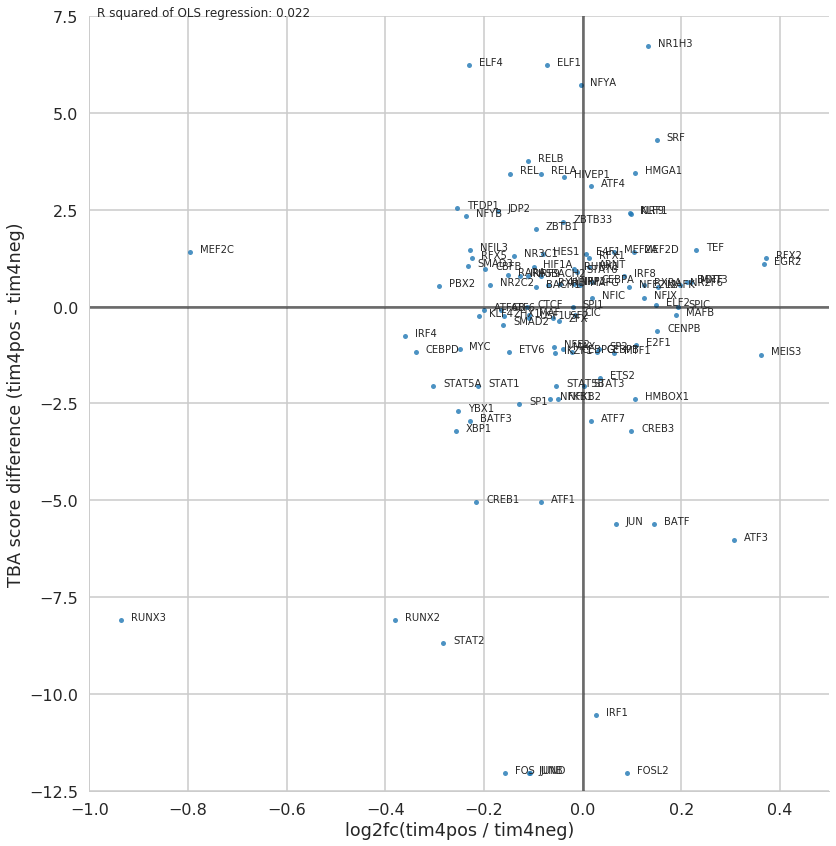

In [138]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet'
samp2 = 'ncorwt_kupffertim4neg_nashdiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / tim4neg)', 'TBA score difference (tim4pos - tim4neg)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-1,0.5])
axes.set_ylim([-12.5,7.5])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4pos_tim4neg_log_log_plot.pdf', bbox_inches='tight')

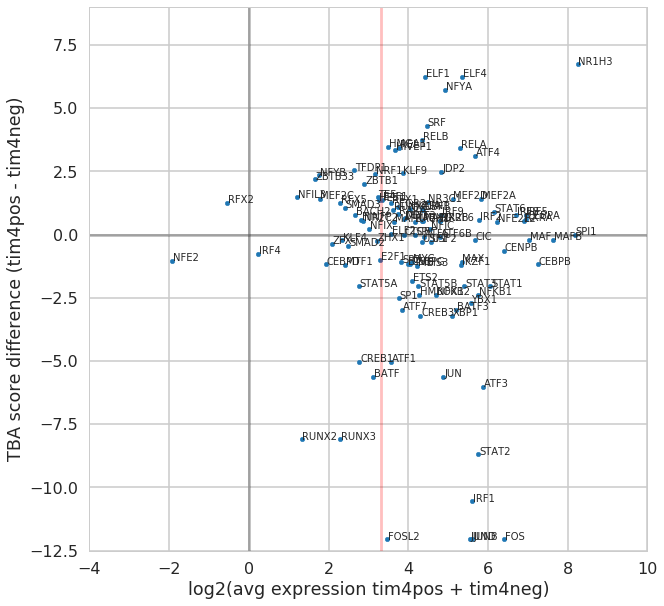

In [128]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + tim4neg)')
plt.ylabel('TBA score difference (tim4pos - tim4neg)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-4,10])
axes.set_ylim([-12.5,9])

plt.savefig('./expression/tim4pos_tim4neg_MAplot.pdf', bbox_inches='tight')

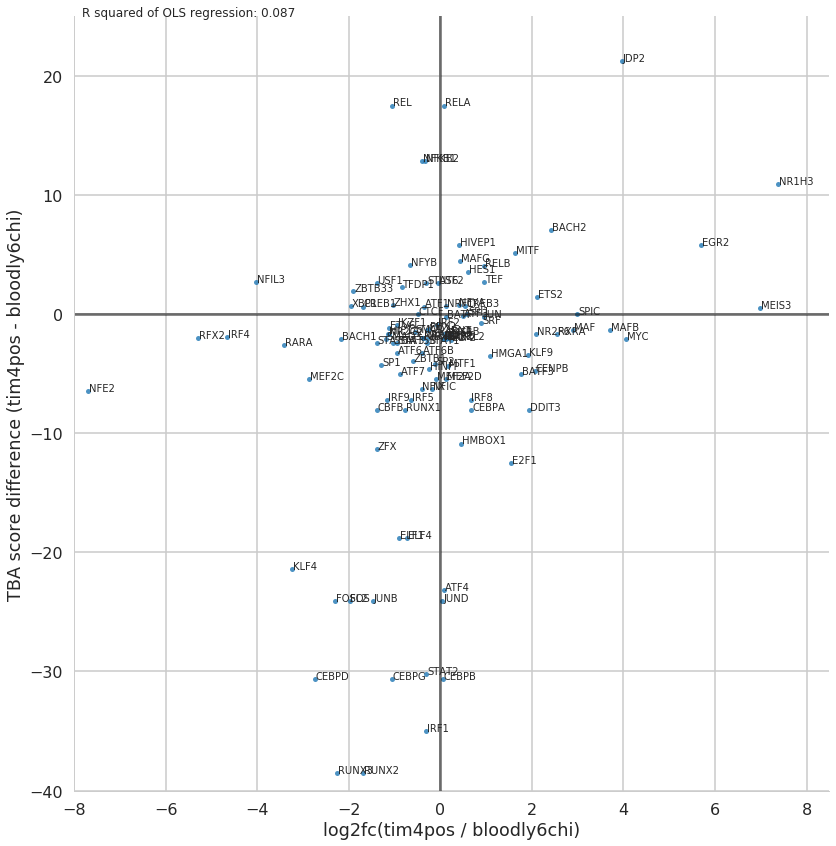

In [140]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet'
samp2 = 'ncorwt_bloodly6chi_controldiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / bloodly6chi)', 'TBA score difference (tim4pos - bloodly6chi)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-8,8.5])
axes.set_ylim([-40,25])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4pos_bloodly6chi_log_log_plot.pdf', bbox_inches='tight')

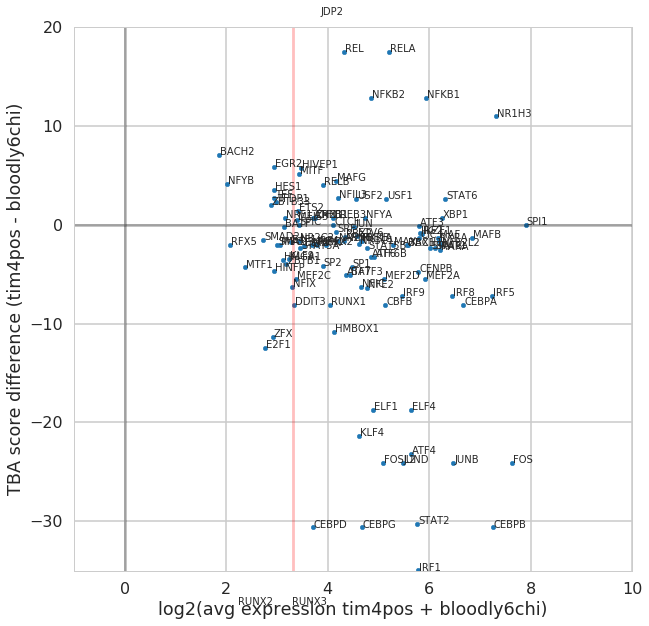

In [130]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + bloodly6chi)')
plt.ylabel('TBA score difference (tim4pos - bloodly6chi)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4pos_bloodly6chi_MAplot.pdf', bbox_inches='tight')

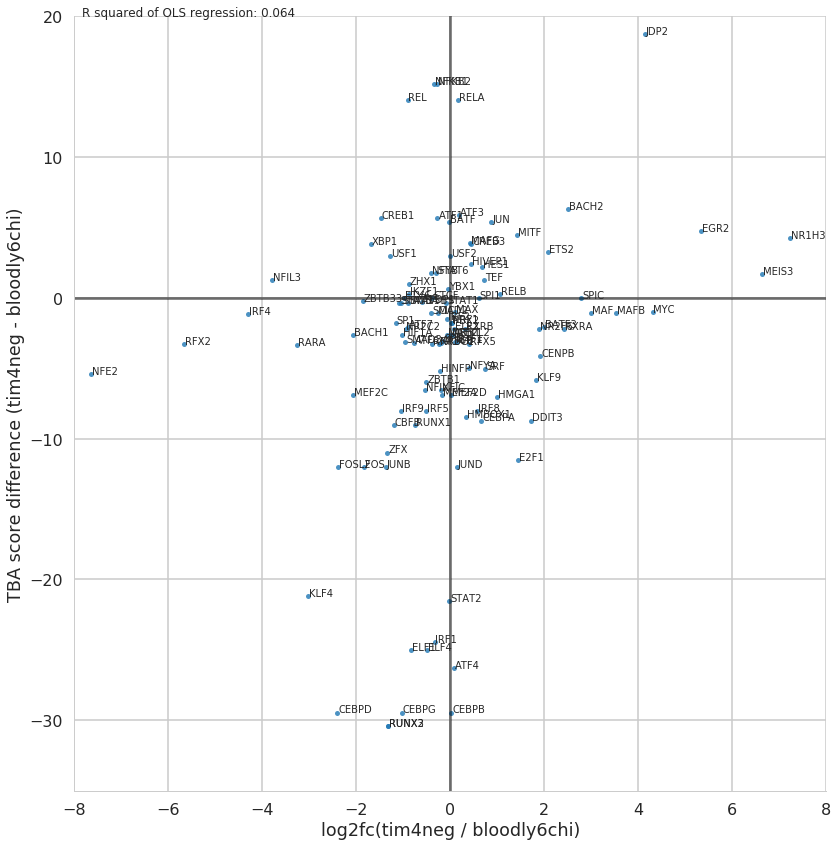

In [141]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet'
samp2 = 'ncorwt_bloodly6chi_controldiet'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg / bloodly6chi)', 'TBA score difference (tim4neg - bloodly6chi)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# plot axes as darker colors
plt.plot([0, 0], [-100, 100], color='k', alpha=0.5)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.5)

# set axis limits
axes = plt.gca()
axes.set_xlim([-8,8])
axes.set_ylim([-35,20])

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./expression/tim4neg_bloodly6chi_log_log_plot.pdf', bbox_inches='tight')

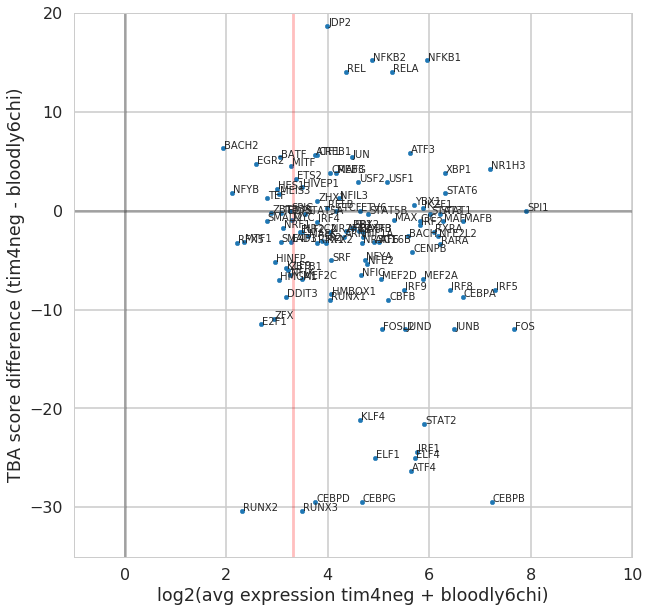

In [132]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg + bloodly6chi)')
plt.ylabel('TBA score difference (tim4neg - bloodly6chi)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4neg_bloodly6chi_MAplot.pdf', bbox_inches='tight')

### Create Table of top positively correlated motifs

In [377]:
pval_threshold = 1e-10
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
# positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,Motif,Mean p-val
CTCF,CTCF,1.000000e-50
Klf12,Klf12,1.000000e-50
Ets-related_1_merged,Ets-related_1_merged,1.000000e-50
IRF1,IRF1,1.000000e-50
Ets-related_2_merged,Ets-related_2_merged,1.000001e-50
STAT1::STAT2,STAT1::STAT2,3.012751e-49
Atf3,Atf3,4.758546e-48
Gabpa,Gabpa,1.042895e-47
NFYA,NFYA,4.740630e-30
Pax2,Pax2,2.150195e-29
